## Imports and preprocessing

In [1]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

# Largest Piece First First Fit

In [2]:
df = pd.read_csv("/Users/yilunli/Desktop/ECE1724_Team10_Project/DatasetGen/synthetic_dataset.csv")
df.rename(columns = {'Number Deliveries':'demand'}, inplace=True)
df.sort_values(by=['demand'], ascending=False, inplace=True)
print(df.columns.tolist())
demands = df["demand"]
df = df[["X", "Y"]]
df["Y"] -= 3000
data = df.to_numpy()

facilities = pd.read_csv("/Users/yilunli/Desktop/ECE1724_Team10_Project/Algorithms/GA/mut0.9_covr0.8_ga_locations.csv")
facilities = facilities[["x", "y"]]
facilities["y"] -= 3000
depots = facilities.to_numpy()

['Node ID', 'Node OSMID', 'X', 'Y', 'Node Weight', 'demand']


In [3]:
min_bid_rent_multiplier = 0.7
max_distance_to_dtwn = np.sqrt(12392630.812723137)
min_distance_to_dtwn = 0 #np.sqrt(8665726.939704213)

# print(min_distance_to_dtwn)

In [4]:
capacity_perfacility = 1200
capacities = capacity_perfacility * np.ones(depots.shape[0])
def get_multiplier(min_bid_rent_multiplier, min_distance_to_dtwn, max_distance_to_dtwn, distances):
    return (1 - min_bid_rent_multiplier *\
                 (distances - min_distance_to_dtwn)\
            / (max_distance_to_dtwn - min_distance_to_dtwn)) * distances

In [5]:
result = np.zeros((data.shape[0], depots.shape[0]))
cost = 0
for i in range(data.shape[0]):
    node = data[i]
    distances = np.linalg.norm(depots - node, axis=1)
    distances = get_multiplier(min_bid_rent_multiplier, min_distance_to_dtwn, max_distance_to_dtwn, distances)
    min_distance_depot = np.argsort(distances)
    for j in min_distance_depot:
        if capacities[j] == 0:
            continue
        if capacities[j] >= demands[i]:
            cost += distances[j] * (demands[i]/1200)
            result[i][j] += demands[i]
            capacities[j] -= demands[i]
            demands[i] = 0
            break
        else:
            cost += distances[j] * (demands[i]/1200)
            result[i][j] += capacities[j]
            demands[i] -= capacities[j]
            capacities[j] = 0
        if demands[i] <= 0:
            break

Verification

In [6]:
print(f"total cost: {cost}")
print(f"left over capacities: {np.sum(capacities[np.nonzero(capacities)[0]])}")
print(f"remaining demand: {np.sum(demands)}")

total cost: 113342.8897969506
left over capacities: 6800.0
remaining demand: 0


# SA

In [13]:
df = pd.read_csv("/Users/yilunli/Desktop/ECE1724_Team10_Project/DatasetGen/synthetic_dataset.csv")
df.rename(columns = {'Number Deliveries':'demand'}, inplace=True)
df.sort_values(by=['demand'], ascending=False, inplace=True)
print(df.columns.tolist())
demands = df["demand"].to_numpy()
df = df[["X", "Y"]]
df["Y"] -= 3000
data = df.to_numpy()

facilities = pd.read_csv("/Users/yilunli/Desktop/ECE1724_Team10_Project/Algorithms/GA/mut0.9_covr0.8_ga_locations.csv")
facilities = facilities[["x", "y"]]
facilities["y"] -= 3000
depots = facilities.to_numpy()

['Node ID', 'Node OSMID', 'X', 'Y', 'Node Weight', 'demand']


In [14]:
import math
import random

def exp_schedule(k=20, lam=0.005, limit=100):
    function = lambda t: (k * np.exp(-lam*t) if t <limit else 0)
    return function

def random_search(coords, volumes, locations): 
    cap = capacity_perfacility * np.ones(locations.shape[0])
    indices = np.arange(coords.shape[0])
    np.random.shuffle(indices)
    da, ds = np.copy(coords)[indices], np.copy(volumes)[indices]
    r = np.zeros((da.shape[0], locations.shape[0]))
    c = 0
    for i in range(da.shape[0]):
        node = da[i]
        distances = np.linalg.norm(locations - node, axis=1)
        distances = get_multiplier(min_bid_rent_multiplier, min_distance_to_dtwn, max_distance_to_dtwn, distances)
        min_distance_depot = np.argsort(distances)
        for j in min_distance_depot:
            if cap[j] == 0:
                continue
            if cap[j] >= ds[i]:
                c += distances[j] * (ds[i]/1200)
                r[i][j] += ds[i]
                cap[j] -= ds[i]
                ds[i] = 0
                break
            else:
                c += distances[j] * (ds[i]/1200)
                r[i][j] += cap[j]
                ds[i] -= cap[j]
                cap[j] = 0
            if ds[i] <= 0:
                break
    return r, c

In [15]:
from smart_mobility_utilities.common import probability

def simulated_annealing(initial_solution, num_iter, schedule_function, neighbour_function, coords, volume, locations):
    current, current_cost = initial_solution
    assert(current_cost != 0)
    states = [current_cost]
    for t in range(num_iter):
        T = schedule_function(t)
        next_choice, next_cost = neighbour_function(coords, volume, locations)
        current_cost = states[-1]
        delta_e = next_cost - current_cost
        if delta_e < 0 or probability(np.exp(-1 * delta_e / T)):
            current = next_choice
            states.append(next_cost)
    return current, states[-1], states

In [16]:
distribution_solution = np.zeros((data.shape[0], depots.shape[0]))
num_iterations = 50
exp_schedule_k = 20
exp_schedule_lam = 0.05
total_cost = 0

schedule = exp_schedule(exp_schedule_k, exp_schedule_lam, num_iterations)
initial_solution = (result, cost)
distribution_solution, total_cost, trace = simulated_annealing(
    initial_solution,
    num_iterations,
    schedule,
    random_search,
    np.copy(data),
    np.copy(demands),
    np.copy(depots)
    )

In [17]:
left_over_capacity = np.sum(1200 * np.ones(839) - np.sum(distribution_solution, axis=0))

print(f"total cost: {total_cost}")
print(f"left over capacities: {np.sum(left_over_capacity)}")
print(f"remaining demand: {np.sum(demands - np.sum(distribution_solution, axis=1))}")

total cost: 90407.74747958986
left over capacities: 6800.0
remaining demand: 0.0


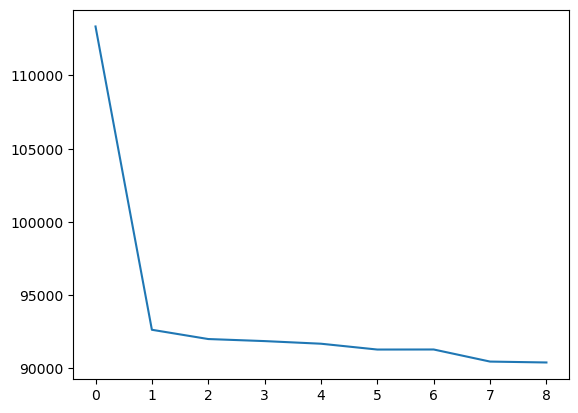

In [18]:
plt.plot(trace)